##### Authors: Mihika Sonalkar and Sam Reynolds
##### Date: 11/20/24
##### Purpose: Creating the supervised thymoma classification models.

# Importing libraries.

In [1]:
import datetime
import random
import math
import autograd.numpy as np
from autograd import grad
import sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import RocCurveDisplay
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import rand_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
import scipy.sparse as sp
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
from statistics import mean, stdev
%matplotlib inline

# Loading data.

In [2]:
betas_file_path = "/Users/samuelreynolds/Desktop/Christensen Lab/Thymoma Classification/Data/combinedBetas_batch_corrected.csv"
pheno_file_path = "/Users/samuelreynolds/Desktop/Christensen Lab/Thymoma Classification/Data/combinedPheno.csv"

combinedBetas_batch_corrected = pd.read_csv(betas_file_path)
combinedPheno = pd.read_csv(pheno_file_path)


combinedBetas_batch_corrected = combinedBetas_batch_corrected.rename(index=combinedBetas_batch_corrected["Unnamed: 0"])
del combinedBetas_batch_corrected["Unnamed: 0"]

combinedPheno = combinedPheno.rename(index=combinedPheno["Unnamed: 0"])
del combinedPheno["Unnamed: 0"]

# Define a mapping of elements to be replaced
replace_dict = {'micronodular': 'M', 'Thymic carcinoma': 'TC'}

# Use the .replace() method to replace elements
combinedPheno['CancerSubtype'] = combinedPheno['CancerSubtype'].replace(replace_dict)


#print("Transposing data.")
combinedBetas_batch_corrected = combinedBetas_batch_corrected.transpose()


In [3]:
# Double checking the rows match and that the beta values are paired with their pheno data
rowNames = list(combinedBetas_batch_corrected.index)
rowNames2 = list(combinedPheno.index)

print (rowNames == rowNames2)

True


In [5]:
combinedPheno_new = combinedPheno[combinedPheno['CancerSubtype'] != 'normal thymus']

In [6]:
combinedPheno_new["CancerSubtype"].replace('atypical A', 'A', inplace=True)

/var/folders/bb/sr6jv42x3zl3mz0gpq05mhwr0000gn/T/ipykernel_19246/2780870193.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combinedPheno_new["CancerSubtype"].replace('atypical A', 'A', inplace=True)
/var/folders/bb/sr6jv42x3zl3mz0gpq05mhwr0000gn/T/ipykernel_19246/2780870193.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combinedPheno

In [10]:
combinedPhenoBetas_new = combinedPheno_new.join(combinedBetas_batch_corrected)

# Building the models.

#### Support vector classification.

In [160]:
#Support Vector Classification
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, roc_auc_score

def runSVC(X,Y):        
    """
    # Initialize k-fold cross-validation
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    """
    # Initialize the classifier
    svc = SVC(kernel='linear', probability=True, random_state=42)
    
    # Performance metrics
    accuracies_train = []
    precisions_train = []
    f1_scores_train = []
    recalls_train = []
    aucs_train = []
    
    accuracies = []
    precisions = []
    f1_scores = []
    recalls = []
    aucs = []

    # Split into training and testing sets
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

    # Fit the model
    svc.fit(X_train, Y_train)
        
    # Predict probabilities and labels
    Y_pred_train = svc.predict(X_train)
    Y_pred = svc.predict(X_test)
    Y_proba_train = svc.predict(X_train)
    Y_proba = svc.predict_proba(X_test)
        
    #Compute training metrics
    accuracies_train.append(accuracy_score(Y_train, Y_pred_train))
    precisions_train.append(precision_score(Y_train, Y_pred_train, average='weighted'))
    f1_scores_train.append(f1_score(Y_train, Y_pred_train, average='weighted'))
    recalls_train.append(recall_score(Y_train, Y_pred_train, average='weighted'))
    #aucs_train.append(roc_auc_score(Y_train, Y_proba_train, multi_class='ovr'))
        
    # Compute metrics
    accuracies.append(accuracy_score(Y_test, Y_pred))
    precisions.append(precision_score(Y_test, Y_pred, average='weighted'))
    f1_scores.append(f1_score(Y_test, Y_pred, average='weighted'))
    recalls.append(recall_score(Y_test, Y_pred, average='weighted'))
        
    # For multi-class AUC, use 'ovr' (One-vs-Rest) strategy
    aucs.append(roc_auc_score(Y_test, Y_proba, multi_class='ovr'))
    
    """
    # Perform k-fold cross-validation
    for train_index, test_index in kf.split(X, Y):
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        
        # Fit the model
        svc.fit(X_train, Y_train)
        
        # Predict probabilities and labels
        Y_pred_train = svc.predict(X_train)
        Y_pred = svc.predict(X_test)
        Y_proba_train = svc.predict(X_train)
        Y_proba = svc.predict_proba(X_test)
    
        #Compute training metrics
        accuracies_train.append(accuracy_score(Y_train, Y_pred_train))
        precisions_train.append(precision_score(Y_train, Y_pred_train, average='weighted'))
        f1_scores_train.append(f1_score(Y_train, Y_pred_train, average='weighted'))
        recalls_train.append(recall_score(Y_train, Y_pred_train, average='weighted'))
        #aucs_train.append(roc_auc_score(Y_train, Y_proba_train, multi_class='ovr'))
        
        # Compute test metrics
        accuracies.append(accuracy_score(Y_test, Y_pred))
        precisions.append(precision_score(Y_test, Y_pred, average='weighted'))
        f1_scores.append(f1_score(Y_test, Y_pred, average='weighted'))
        recalls.append(recall_score(Y_test, Y_pred, average='weighted'))
        aucs.append(roc_auc_score(Y_test, Y_proba, multi_class='ovr'))
    """
    
    #Calculate train metrics
    mean_accuracy_train = np.mean(accuracies_train)
    mean_precision_train = np.mean(precisions_train)
    mean_f1_train = np.mean(f1_scores_train)
    mean_recall_train = np.mean(recalls_train)
    mean_auc_train = np.mean(aucs_train)
        
    # Calculate mean metrics
    mean_accuracy = np.mean(accuracies)
    mean_precision = np.mean(precisions)
    mean_f1 = np.mean(f1_scores)
    mean_recall = np.mean(recalls)
    mean_auc = np.mean(aucs)
    
    #Display the results
    print(f"Mean Train Accuracy: {mean_accuracy_train}")
    print(f"Mean Train Precision: {mean_precision_train}")
    print(f"Mean Train F1 Score: {mean_f1_train}")
    print(f"Mean Train Recall: {mean_recall_train}")
    #print(f"Mean Train AUC: {mean_auc_train}")
    
    # Display the results
    print()
    print(f"Mean Test Accuracy: {mean_accuracy}")
    print(f"Mean Test Precision: {mean_precision}")
    print(f"Mean Test F1 Score: {mean_f1}")
    print(f"Mean Test Recall: {mean_recall}")
    print(f"Mean Test AUC: {mean_auc}")

    return(mean_accuracy, Y_pred)

#### Extreme gradient boosting classification.

In [156]:
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

def runXGB(X, Y):
    # Encode the target labels as integers
    label_encoder = LabelEncoder()
    Y_encoded = label_encoder.fit_transform(Y)
    """
    # Initialize k-fold cross-validation
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    """
    # Initialize the XGBoost classifier
    xgb = XGBClassifier(
        use_label_encoder=False, 
        eval_metric='mlogloss', 
        #max_depth=3, 
        #subsample=0.8, 
        reg_alpha = 1,
        #colsample_bytree=0.8, 
        #n_estimators=100,
        #tree_method='hist',
        random_state=42)
    
    #Performance metrics
    accuracies_train = []
    precisions_train = []
    f1_scores_train = []
    recalls_train = []
    aucs_train = []
    
    # Performance metrics
    accuracies = []
    precisions = []
    f1_scores = []
    recalls = []
    aucs = []

    # Split into training and testing sets
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y_encoded, test_size=0.2, random_state=42)

    # Fit the model
    xgb.fit(X_train, Y_train)
        
    # Predict probabilities and labels
    Y_pred_train = xgb.predict(X_train)
    Y_pred = xgb.predict(X_test)
    Y_proba_train = xgb.predict(X_train)
    Y_proba = xgb.predict_proba(X_test)
        
    #Compute training metrics
    accuracies_train.append(accuracy_score(Y_train, Y_pred_train))
    precisions_train.append(precision_score(Y_train, Y_pred_train, average='weighted'))
    f1_scores_train.append(f1_score(Y_train, Y_pred_train, average='weighted'))
    recalls_train.append(recall_score(Y_train, Y_pred_train, average='weighted'))
    #aucs_train.append(roc_auc_score(Y_train, Y_proba_train, multi_class='ovr'))
        
    # Compute metrics
    accuracies.append(accuracy_score(Y_test, Y_pred))
    precisions.append(precision_score(Y_test, Y_pred, average='weighted'))
    f1_scores.append(f1_score(Y_test, Y_pred, average='weighted'))
    recalls.append(recall_score(Y_test, Y_pred, average='weighted'))
        
    # For multi-class AUC, use 'ovr' (One-vs-Rest) strategy
    aucs.append(roc_auc_score(Y_test, Y_proba, multi_class='ovr'))
    
    """
    # Perform k-fold cross-validation
    for train_index, test_index in kf.split(X, Y):
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y_encoded[train_index], Y_encoded[test_index]
    
        
        # Fit the model
        xgb.fit(X_train, Y_train)
        
        # Predict probabilities and labels
        Y_pred_train = xgb.predict(X_train)
        Y_pred = xgb.predict(X_test)
        Y_proba_train = xgb.predict(X_train)
        Y_proba = xgb.predict_proba(X_test)
        
        #Compute training metrics
        accuracies_train.append(accuracy_score(Y_train, Y_pred_train))
        precisions_train.append(precision_score(Y_train, Y_pred_train, average='weighted'))
        f1_scores_train.append(f1_score(Y_train, Y_pred_train, average='weighted'))
        recalls_train.append(recall_score(Y_train, Y_pred_train, average='weighted'))
        #aucs_train.append(roc_auc_score(Y_train, Y_proba_train, multi_class='ovr'))
        
        # Compute metrics
        accuracies.append(accuracy_score(Y_test, Y_pred))
        precisions.append(precision_score(Y_test, Y_pred, average='weighted'))
        f1_scores.append(f1_score(Y_test, Y_pred, average='weighted'))
        recalls.append(recall_score(Y_test, Y_pred, average='weighted'))
        
        # For multi-class AUC, use 'ovr' (One-vs-Rest) strategy
        aucs.append(roc_auc_score(Y_test, Y_proba, multi_class='ovr'))
    """
    #Calculate train metrics
    mean_accuracy_train = np.mean(accuracies_train)
    mean_precision_train = np.mean(precisions_train)
    mean_f1_train = np.mean(f1_scores_train)
    mean_recall_train = np.mean(recalls_train)
    mean_auc_train = np.mean(aucs_train)
    
    # Calculate test metrics
    mean_accuracy = np.mean(accuracies)
    mean_precision = np.mean(precisions)
    mean_f1 = np.mean(f1_scores)
    mean_recall = np.mean(recalls)
    mean_auc = np.mean(aucs)
    
    #Display the results
    print(f"Mean Train Accuracy: {mean_accuracy_train}")
    print(f"Mean Train Precision: {mean_precision_train}")
    print(f"Mean Train F1 Score: {mean_f1_train}")
    print(f"Mean Train Recall: {mean_recall_train}")
    #print(f"Mean Train AUC: {mean_auc_train}")
    
    # Display the results
    print()
    print(f"Mean Accuracy: {mean_accuracy}")
    print(f"Mean Precision: {mean_precision}")
    print(f"Mean F1 Score: {mean_f1}")
    print(f"Mean Recall: {mean_recall}")
    print(f"Mean AUC: {mean_auc}")

    return(mean_accuracy, Y_pred)

### Multilayer perceptron.

In [259]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

def runMLP(X):
    # Preprocess the target variable (One-Hot Encoding)
    one_hot_encoder = OneHotEncoder(sparse_output=False)
    Y_encoded = one_hot_encoder.fit_transform(combinedPhenoBetas_new["CancerSubtype"].values.reshape(-1, 1))
    
    # Standardize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Split into training and testing sets
    X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y_encoded, test_size=0.2, random_state=42)
    
    # Define the Multilayer Perceptron model
    model = Sequential([
        Dense(256, activation='relu', input_dim=X_train.shape[1]),  # Input/First layer
        Dropout(0.1),  # Dropout for regularization
        Dense(128, activation='relu'),  # Second layer
        Dropout(0.2),
        Dense(64, activation='relu'),  # Third layer
        Dropout(0.2),
        Dense(Y_train.shape[1], activation='softmax')  # Fifth layer (Output layer)
    ])
    
    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Train the model
    history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=50, batch_size=32)

    # Predict on the test set
    Y_pred_probs = model.predict(X_test)
    
    # Convert the predicted one-hot encoded vectors back to class indices
    Y_pred_class_indices = Y_pred_probs.argmax(axis=1)
    
    # Convert the class indices back to the original string labels
    Y_pred_classes = one_hot_encoder.categories_[0][Y_pred_class_indices]
    
    # Evaluate the model
    loss, accuracy = model.evaluate(X_test, Y_test)
    print(f"Test Loss: {loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")
    
    # Save the model
    model.save("mlp_model.h5")
    return(accuracy, Y_pred_classes, Y_pred_probs)


### Models just using beta values.

#### Dimentionality reduction.

##### PCA

In [ ]:
from sklearn.decomposition import PCA
#PCA to reduce dimensions - n-components = 200
pca200=PCA(n_components=200)
combinedBetas_batch_corrected_pca200=pca200.fit_transform(combinedPhenoBetas_new.drop(columns=["Age","Sex","CancerType","CancerSubtype"]))

In [ ]:
#PCA to reduce dimensions - n-components = 20
pca20=PCA(n_components=20)
combinedBetas_batch_corrected_pca20=pca20.fit_transform(combinedPhenoBetas_new.drop(columns=["Age","Sex","CancerType","CancerSubtype"]))

In [ ]:
X_20 = combinedBetas_batch_corrected_pca20
X_200 = combinedBetas_batch_corrected_pca200
Y = combinedPhenoBetas_new["CancerSubtype"].values

##### K-Best

In [183]:
from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectKBest, chi2
X = combinedPhenoBetas_new.drop(columns=["Age","Sex","CancerType","CancerSubtype"])
Y = combinedPhenoBetas_new["CancerSubtype"].values
print(X.shape)
X_Kbest = SelectKBest(k=300).fit_transform(X, Y)
print(X_Kbest.shape)

(200, 371902)
(200, 300)


### Running the models.

#### PCA

In [162]:
# SVC PCA 200
SVC_PCA_200 = runSVC(X_200,Y)

Mean Train Accuracy: 1.0
Mean Train Precision: 1.0
Mean Train F1 Score: 1.0
Mean Train Recall: 1.0

Mean Test Accuracy: 0.8
Mean Test Precision: 0.85
Mean Test F1 Score: 0.8074603174603174
Mean Test Recall: 0.8
Mean Test AUC: 0.967425566656709


/opt/anaconda3/envs/MED264FinalProject/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/MED264FinalProject/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [163]:
# SVC PCA 20
SVC_PCA_20 = runSVC(X_20,Y)

Mean Train Accuracy: 0.93125
Mean Train Precision: 0.9323240599593495
Mean Train F1 Score: 0.9307997229064039
Mean Train Recall: 0.93125

Mean Test Accuracy: 0.625
Mean Test Precision: 0.7233333333333334
Mean Test F1 Score: 0.6362213950923629
Mean Test Recall: 0.625
Mean Test AUC: 0.9566531615552353


/opt/anaconda3/envs/MED264FinalProject/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/MED264FinalProject/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [164]:
# XGB PCA 200
XGB_PCA_200 = runXGB(X_200,Y)

/opt/anaconda3/envs/MED264FinalProject/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:49:41] WARNING: /var/folders/c_/qfmhj66j0tn016nkx_th4hxm0000gp/T/abs_b6qk1lz_ug/croot/xgboost-split_1724073748391/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Mean Train Accuracy: 1.0
Mean Train Precision: 1.0
Mean Train F1 Score: 1.0
Mean Train Recall: 1.0

Mean Accuracy: 0.675
Mean Precision: 0.7148901098901098
Mean F1 Score: 0.6831109742747674
Mean Recall: 0.675
Mean AUC: 0.9415442816261395


/opt/anaconda3/envs/MED264FinalProject/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/MED264FinalProject/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/MED264FinalProject/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [165]:
# XGB PCA 20
XGB_PCA_20 = runXGB(X_20,Y)

/opt/anaconda3/envs/MED264FinalProject/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:49:56] WARNING: /var/folders/c_/qfmhj66j0tn016nkx_th4hxm0000gp/T/abs_b6qk1lz_ug/croot/xgboost-split_1724073748391/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Mean Train Accuracy: 1.0
Mean Train Precision: 1.0
Mean Train F1 Score: 1.0
Mean Train Recall: 1.0

Mean Accuracy: 0.65
Mean Precision: 0.6802380952380952
Mean F1 Score: 0.6568055555555556
Mean Recall: 0.65
Mean AUC: 0.9094505245084313


/opt/anaconda3/envs/MED264FinalProject/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/MED264FinalProject/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [234]:
# MLP PCA 200
MLP_PCA_200 = runMLP(X_200)

Epoch 1/50
5/5 [==============================] - 1s 55ms/step - loss: 2.1111 - accuracy: 0.1937 - val_loss: 1.7677 - val_accuracy: 0.3750
Epoch 2/50
5/5 [==============================] - 0s 10ms/step - loss: 1.7071 - accuracy: 0.2875 - val_loss: 1.7716 - val_accuracy: 0.3000
Epoch 3/50
5/5 [==============================] - 0s 10ms/step - loss: 1.5469 - accuracy: 0.4062 - val_loss: 1.7483 - val_accuracy: 0.3000
Epoch 4/50
5/5 [==============================] - 0s 10ms/step - loss: 1.3430 - accuracy: 0.5188 - val_loss: 1.7263 - val_accuracy: 0.2750
Epoch 5/50
5/5 [==============================] - 0s 11ms/step - loss: 1.2179 - accuracy: 0.6250 - val_loss: 1.7069 - val_accuracy: 0.3500
Epoch 6/50
5/5 [==============================] - 0s 12ms/step - loss: 1.0560 - accuracy: 0.7125 - val_loss: 1.7083 - val_accuracy: 0.3750
Epoch 7/50
5/5 [==============================] - 0s 12ms/step - loss: 0.9230 - accuracy: 0.7937 - val_loss: 1.7223 - val_accuracy: 0.3500
Epoch 8/50
5/5 [===========

In [260]:
# MLP PCA 20
MLP_PCA_20 = runMLP(X_20)

Epoch 1/50
5/5 [==============================] - 1s 59ms/step - loss: 1.9516 - accuracy: 0.2688 - val_loss: 1.8437 - val_accuracy: 0.4750
Epoch 2/50
5/5 [==============================] - 0s 10ms/step - loss: 1.8128 - accuracy: 0.4000 - val_loss: 1.7468 - val_accuracy: 0.6250
Epoch 3/50
5/5 [==============================] - 0s 10ms/step - loss: 1.6950 - accuracy: 0.5375 - val_loss: 1.6479 - val_accuracy: 0.6000
Epoch 4/50
5/5 [==============================] - 0s 10ms/step - loss: 1.5567 - accuracy: 0.5562 - val_loss: 1.5179 - val_accuracy: 0.6500
Epoch 5/50
5/5 [==============================] - 0s 11ms/step - loss: 1.4535 - accuracy: 0.6313 - val_loss: 1.3812 - val_accuracy: 0.7500
Epoch 6/50
5/5 [==============================] - 0s 11ms/step - loss: 1.2776 - accuracy: 0.6062 - val_loss: 1.2459 - val_accuracy: 0.7500
Epoch 7/50
5/5 [==============================] - 0s 11ms/step - loss: 1.1884 - accuracy: 0.6500 - val_loss: 1.1253 - val_accuracy: 0.7500
Epoch 8/50
5/5 [===========

In [265]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
Y_pred = MLP_PCA_20[1]
Y_prob = MLP_PCA_20[2]
print("Precision: ", precision_score(Y_test, Y_pred, average='weighted'))
print("F1: ", f1_score(Y_test, Y_pred, average='weighted'))
print("Recall: ", recall_score(Y_test, Y_pred, average='weighted'))
print("AUC: ", roc_auc_score(Y_test, Y_prob, multi_class="ovr"))

Precision:  0.7841666666666666
F1:  0.7301587301587302
Recall:  0.725
AUC:  0.917480616357496


#### K-best

In [184]:
# SVC K-best 300
SVC_Kbest_300 = runSVC(X_Kbest,Y)

Mean Train Accuracy: 0.90625
Mean Train Precision: 0.9095160889448568
Mean Train F1 Score: 0.9064573655762971
Mean Train Recall: 0.90625

Mean Test Accuracy: 0.8
Mean Test Precision: 0.8185416666666665
Mean Test F1 Score: 0.8041830065359477
Mean Test Recall: 0.8
Mean Test AUC: 0.97972657816855


/opt/anaconda3/envs/MED264FinalProject/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/MED264FinalProject/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [185]:
# XGB K-best 1000
XGB_Kbest_300 = runXGB(X_Kbest,Y)

/opt/anaconda3/envs/MED264FinalProject/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:57:53] WARNING: /var/folders/c_/qfmhj66j0tn016nkx_th4hxm0000gp/T/abs_b6qk1lz_ug/croot/xgboost-split_1724073748391/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Mean Train Accuracy: 1.0
Mean Train Precision: 1.0
Mean Train F1 Score: 1.0
Mean Train Recall: 1.0

Mean Accuracy: 0.775
Mean Precision: 0.8404166666666667
Mean F1 Score: 0.7829365079365079
Mean Recall: 0.775
Mean AUC: 0.9709139688049159


/opt/anaconda3/envs/MED264FinalProject/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/MED264FinalProject/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [279]:
# MLP K-best 1000
MLP_Kbest_300 = runMLP(X_Kbest)

Epoch 1/50
5/5 [==============================] - 1s 55ms/step - loss: 1.6788 - accuracy: 0.4500 - val_loss: 1.2198 - val_accuracy: 0.6750
Epoch 2/50
5/5 [==============================] - 0s 10ms/step - loss: 1.2874 - accuracy: 0.5625 - val_loss: 0.9041 - val_accuracy: 0.7000
Epoch 3/50
5/5 [==============================] - 0s 11ms/step - loss: 1.0746 - accuracy: 0.6250 - val_loss: 0.9029 - val_accuracy: 0.6500
Epoch 4/50
5/5 [==============================] - 0s 11ms/step - loss: 0.9004 - accuracy: 0.6687 - val_loss: 0.7889 - val_accuracy: 0.6500
Epoch 5/50
5/5 [==============================] - 0s 12ms/step - loss: 0.8485 - accuracy: 0.7000 - val_loss: 0.7316 - val_accuracy: 0.7250
Epoch 6/50
5/5 [==============================] - 0s 11ms/step - loss: 0.8223 - accuracy: 0.7188 - val_loss: 0.6487 - val_accuracy: 0.7250
Epoch 7/50
5/5 [==============================] - 0s 10ms/step - loss: 0.7438 - accuracy: 0.7312 - val_loss: 0.6417 - val_accuracy: 0.7000
Epoch 8/50
5/5 [===========

In [280]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
Y_pred = MLP_Kbest_300[1]
Y_prob = MLP_Kbest_300[2]
print("Precision: ", precision_score(Y_test, Y_pred, average='weighted'))
print("F1: ", f1_score(Y_test, Y_pred, average='weighted'))
print("Recall: ", recall_score(Y_test, Y_pred, average='weighted'))
print("AUC: ", roc_auc_score(Y_test, Y_prob, multi_class="ovr"))

Precision:  0.8466666666666667
F1:  0.8195383986928105
Recall:  0.825
AUC:  0.9542674079891367


### Plotting confusion matrix.

In [281]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

confusion_matrix = sklearn.metrics.confusion_matrix(y_true=Y_test, y_pred=MLP_Kbest_300[1], labels=np.unique(Y_test).tolist())
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix,
                               display_labels=np.unique(Y_test).tolist())

In [245]:
Y_test

array(['B3', 'M', 'AB', 'B2', 'AB', 'B3', 'B2', 'AB', 'A', 'AB', 'B2',
       'AB', 'AB', 'B2', 'B2', 'AB', 'B1', 'B2', 'B2', 'B2', 'B1', 'M',
       'B2', 'B2', 'B2', 'B1', 'B2', 'B2', 'B1', 'TC', 'M', 'M', 'B1',
       'B2', 'B2', 'B3', 'A', 'AB', 'AB', 'B2'], dtype=object)

In [246]:
MLP_Kbest_300[1]

array(['B3', 'M', 'AB', 'B2', 'A', 'M', 'B2', 'AB', 'A', 'AB', 'B2', 'AB',
       'AB', 'B2', 'B2', 'AB', 'B1', 'B2', 'B2', 'B2', 'B2', 'M', 'B2',
       'B2', 'B2', 'B2', 'B2', 'B2', 'B1', 'TC', 'M', 'M', 'B2', 'B1',
       'B2', 'B3', 'A', 'AB', 'A', 'B2'], dtype=object)

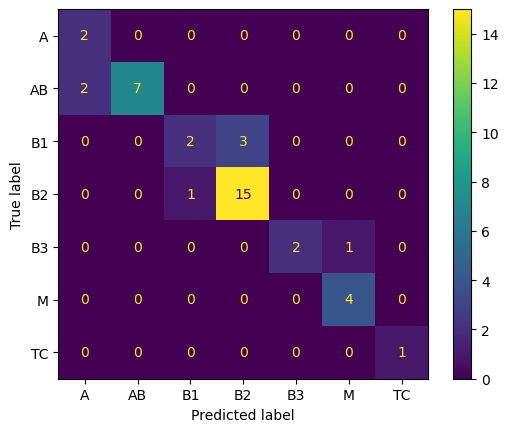

In [282]:
disp.plot()
plt.show()

In [117]:
k = range(0,1000,100)
test_accuracies = []
for i in k:
    X_Kselected = SelectKBest(k=i+1).fit_transform(X, Y)
    test_accuracy = runSVC(X_Kselected,Y)
    test_accuracies.append(test_accuracy)
print(test_accuracies)

/opt/anaconda3/envs/MED264FinalProject/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/MED264FinalProject/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/MED264FinalProject/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

Mean Train Accuracy: 0.28375000000000006
Mean Train Precision: 0.11254819787131107
Mean Train F1 Score: 0.1326817504588042
Mean Train Recall: 0.28375000000000006

Mean Test Accuracy: 0.27999999999999997
Mean Test Precision: 0.08601282051282051
Mean Test F1 Score: 0.12576862745098039
Mean Test Recall: 0.27999999999999997
Mean Test AUC: 0.6047640084585897


/opt/anaconda3/envs/MED264FinalProject/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/MED264FinalProject/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/MED264FinalProject/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

Mean Train Accuracy: 0.82
Mean Train Precision: 0.8147413748982807
Mean Train F1 Score: 0.8003477699068057
Mean Train Recall: 0.82

Mean Test Accuracy: 0.7550000000000001
Mean Test Precision: 0.7514535256410256
Mean Test F1 Score: 0.7316624281727258
Mean Test Recall: 0.7550000000000001
Mean Test AUC: 0.9525112781853773


/opt/anaconda3/envs/MED264FinalProject/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/MED264FinalProject/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/MED264FinalProject/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Mean Train Accuracy: 0.9012500000000001
Mean Train Precision: 0.9073063051484128
Mean Train F1 Score: 0.9006634624269418
Mean Train Recall: 0.9012500000000001

Mean Test Accuracy: 0.745
Mean Test Precision: 0.7530302197802198
Mean Test F1 Score: 0.7362212662750419
Mean Test Recall: 0.745
Mean Test AUC: 0.9494693138552355


/opt/anaconda3/envs/MED264FinalProject/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/MED264FinalProject/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/MED264FinalProject/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Mean Train Accuracy: 0.9275
Mean Train Precision: 0.9312367907904472
Mean Train F1 Score: 0.9277682001206502
Mean Train Recall: 0.9275

Mean Test Accuracy: 0.77
Mean Test Precision: 0.7798333333333334
Mean Test F1 Score: 0.7648514223508502
Mean Test Recall: 0.77
Mean Test AUC: 0.9530543251988677


/opt/anaconda3/envs/MED264FinalProject/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/MED264FinalProject/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/MED264FinalProject/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Mean Train Accuracy: 0.95375
Mean Train Precision: 0.9555626337418148
Mean Train F1 Score: 0.9538619640468505
Mean Train Recall: 0.95375

Mean Test Accuracy: 0.755
Mean Test Precision: 0.7585143467643467
Mean Test F1 Score: 0.7470430242272348
Mean Test Recall: 0.755
Mean Test AUC: 0.949995421595629


/opt/anaconda3/envs/MED264FinalProject/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/MED264FinalProject/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/MED264FinalProject/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Mean Train Accuracy: 0.9737499999999999
Mean Train Precision: 0.9748251649100442
Mean Train F1 Score: 0.9738460147429899
Mean Train Recall: 0.9737499999999999

Mean Test Accuracy: 0.75
Mean Test Precision: 0.7548237179487179
Mean Test F1 Score: 0.7429542763364274
Mean Test Recall: 0.75
Mean Test AUC: 0.951229008775029


/opt/anaconda3/envs/MED264FinalProject/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/MED264FinalProject/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/MED264FinalProject/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Mean Train Accuracy: 0.98125
Mean Train Precision: 0.9820891280710665
Mean Train F1 Score: 0.9812920098157021
Mean Train Recall: 0.98125

Mean Test Accuracy: 0.75
Mean Test Precision: 0.7546115689865689
Mean Test F1 Score: 0.7424692710035959
Mean Test Recall: 0.75
Mean Test AUC: 0.9498310473819936


/opt/anaconda3/envs/MED264FinalProject/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/MED264FinalProject/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/MED264FinalProject/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Mean Train Accuracy: 0.9837499999999999
Mean Train Precision: 0.9842950104240076
Mean Train F1 Score: 0.9837581754268943
Mean Train Recall: 0.9837499999999999

Mean Test Accuracy: 0.74
Mean Test Precision: 0.7522083333333334
Mean Test F1 Score: 0.733226892990051
Mean Test Recall: 0.74
Mean Test AUC: 0.9496542286017269


/opt/anaconda3/envs/MED264FinalProject/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/MED264FinalProject/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/MED264FinalProject/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Mean Train Accuracy: 0.99125
Mean Train Precision: 0.9915656673610249
Mean Train F1 Score: 0.9912728311197914
Mean Train Recall: 0.99125

Mean Test Accuracy: 0.7549999999999999
Mean Test Precision: 0.7608161421911422
Mean Test F1 Score: 0.7478879444989286
Mean Test Recall: 0.7549999999999999
Mean Test AUC: 0.9512766113965233
Mean Train Accuracy: 0.9974999999999999
Mean Train Precision: 0.9975568181818183
Mean Train F1 Score: 0.9974999999999999
Mean Train Recall: 0.9974999999999999

Mean Test Accuracy: 0.7549999999999999
Mean Test Precision: 0.7598338467088467
Mean Test F1 Score: 0.7474889545999386
Mean Test Recall: 0.7549999999999999
Mean Test AUC: 0.9509670391731581
[0.27999999999999997, 0.7550000000000001, 0.745, 0.77, 0.755, 0.75, 0.75, 0.74, 0.7549999999999999, 0.7549999999999999]


/opt/anaconda3/envs/MED264FinalProject/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/MED264FinalProject/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/MED264FinalProject/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


/var/folders/bb/sr6jv42x3zl3mz0gpq05mhwr0000gn/T/ipykernel_19246/2994462112.py:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


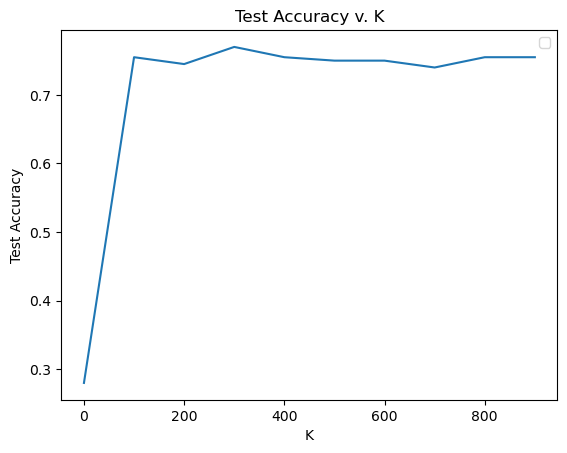

In [118]:
plt.plot(k, test_accuracies)
plt.xlabel('K')
plt.ylabel('Test Accuracy')
plt.legend()
plt.title('Test Accuracy v. K')
plt.show()